## 目的
本ノートブックでは、重力波という物理現象を検出するための機械学習を用いた分類モデルを構築する。  
機械学習のアルゴリズムには畳み込みニューラルネットワークを用い、画像中の重力波の有無を判別する二値分類モデルを構築する。

#### 学習に用いたデータセット

1.重力波が含まれた画像5000枚  
2.重力波が含まれていないノイズのみの画像5000枚  
それぞれ5000枚のうち2000枚はGAN(敵対的生成ネットワーク)により作成




In [ ]:
#ライブラリインポート
import torch    
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import japanize_matplotlib

In [ ]:
#シード固定
import random     
torch.manual_seed(12)
np.random.seed(12)
random.seed(12)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Transform定義
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

## データセット読み込み

torch.Size([3, 32, 32])
10000


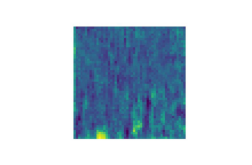

1


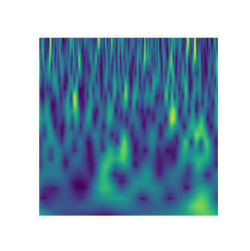

0


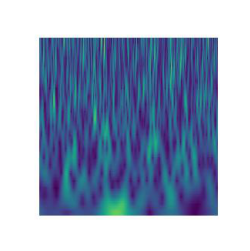

0


In [ ]:
from pathlib import Path
#train 5~40 3000Mpc
train_image_dir = './images/images5/train'
val_image_dir = './images/images5/val'

test2_image_dir = './images/images5000/test2'
test3000_image_dir = './images/images5000/test3000'
test4000_image_dir = './images/images5000/test4000'
actual_image_dir = './images/actual2'
grav_image_dir = './images/gravimage2'


train_dataset = torchvision.datasets.ImageFolder(root=train_image_dir, transform=transform)
validation_dataset = torchvision.datasets.ImageFolder(root=val_image_dir, transform=transform)
test2_dataset = torchvision.datasets.ImageFolder(root=test2_image_dir, transform=transform)
test3000_dataset = torchvision.datasets.ImageFolder(root=test3000_image_dir, transform=transform)
test4000_dataset = torchvision.datasets.ImageFolder(root=test4000_image_dir, transform=transform)
actual_dataset = torchvision.datasets.ImageFolder(root=actual_image_dir, transform=transform)
grav_dataset = torchvision.datasets.ImageFolder(root=grav_image_dir, transform=transform)





image1,label1 = train_dataset[0]
print(image1.shape)

dataset = torchvision.datasets.ImageFolder(root=train_image_dir)
#datasetactual = torchvision.datasets.ImageFolder(root=actual_image_dir)
image,label = dataset[8000]
image2,label2 = dataset[0]

#image3,label3 = datasetactual[0]
image4,label4 = dataset[2]

print(len(dataset))
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(image)
plt.show()
print(label)
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(image2)
plt.show()
print(label2)


plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(image4)
plt.show()
print(label4)







In [ ]:
#データローダー
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test2_dataloader = DataLoader(test2_dataset, batch_size=1, shuffle=False)
test3000_dataloader = DataLoader(test3000_dataset, batch_size=1, shuffle=False)
test4000_dataloader = DataLoader(test4000_dataset, batch_size=1, shuffle=False)
actual_dataloader = DataLoader(actual_dataset, batch_size=1, shuffle=False)
grav_dataloader = DataLoader(grav_dataset, batch_size=1, shuffle=False)

In [ ]:
print(len(actual_dataloader))
print(len(test2_dataloader))
print(len(test3000_dataloader))
print(len(test4000_dataloader))
print(len(train_dataloader))
print(len(validation_dataloader))
print(len(grav_dataloader))

10
2000
2000
2000
40
32
76


## CNNモデル定義

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = CNN(2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

## 学習・検証

In [ ]:
import time
num_epocs = 30
losses = []
accs = []
val_losses = []
val_accs = []
time_sta = time.time()
for epoch in range(num_epocs):
    # 学習
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    
    # 検証
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}    " \
    "val_epoch: {}, val_loss: {}, val_acc: {}".format(epoch, running_loss, running_acc, epoch, val_running_loss, val_running_acc)) 
time_end = time.time()
tim = time_end- time_sta
print(tim)

epoch: 0, loss: 0.5559887751936913, acc: 0.664843738079071    val_epoch: 0, val_loss: 0.2201798283495009, val_acc: 0.900390625
epoch: 1, loss: 0.3515169724822044, acc: 0.8231445550918579    val_epoch: 1, val_loss: 0.09629193204455078, val_acc: 0.96337890625
epoch: 2, loss: 0.1709004331380129, acc: 0.931835949420929    val_epoch: 2, val_loss: 0.04073670307116117, val_acc: 0.98681640625
epoch: 3, loss: 0.09836937710642815, acc: 0.9649413824081421    val_epoch: 3, val_loss: 0.02466145419566601, val_acc: 0.9931640625
epoch: 4, loss: 0.07661514040082693, acc: 0.971972644329071    val_epoch: 4, val_loss: 0.025036251861820347, val_acc: 0.990234375
epoch: 5, loss: 0.04717613514512777, acc: 0.98388671875    val_epoch: 5, val_loss: 0.015632698923980115, val_acc: 0.9931640625
epoch: 6, loss: 0.03640744301956147, acc: 0.986523449420929    val_epoch: 6, val_loss: 0.021198624484441098, val_acc: 0.990234375
epoch: 7, loss: 0.028382291155867278, acc: 0.9916015863418579    val_epoch: 7, val_loss: 0.020

##　学習・検証結果確認

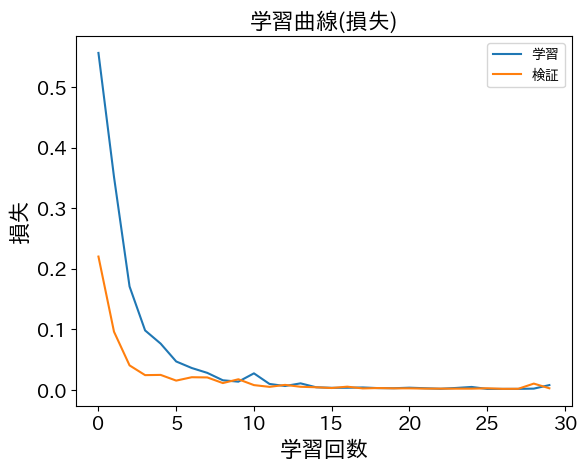

In [ ]:
plt.plot(losses, label='学習')
plt.plot(val_losses, label='検証')
plt.title('学習曲線(損失)',fontsize=16)
plt.xlabel('学習回数',fontsize=16)
plt.ylabel('損失',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(-0.001,0.015)
plt.legend()

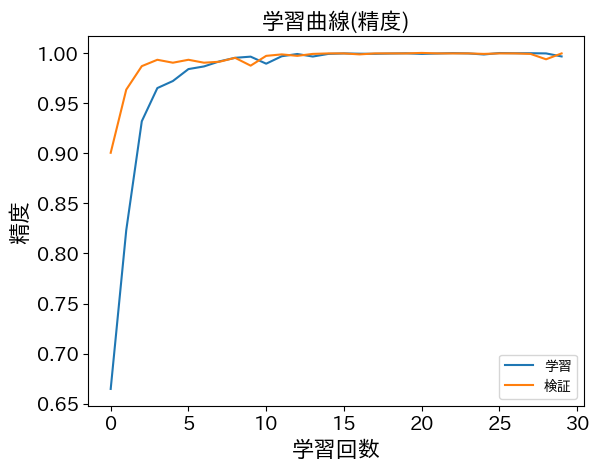

In [ ]:
import japanize_matplotlib
plt.plot(accs, label='学習')
plt.plot(val_accs, label='検証')
plt.xlabel('学習回数',fontsize=16)
plt.ylabel('精度',fontsize=16)
plt.title('学習曲線(精度)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(0.85,1.002)
plt.legend()

## テスト

In [ ]:
#test3000 5~20 3000 images5000
test_running_loss = 0.0
test_running_acc = 0.0
test_losses =[]
test_accs = []
pre = []
ans = []
pre2 = []
for test_imgs, test_labels in test3000_dataloader:
    test_imgs = test_imgs.to(device)
    test_labels = test_labels.to(device)
    test_output = model(test_imgs)
    
    list1 = test_output.tolist()
    for i in range(len(list1)):
        pre.append(list1[i][1])
    loss = criterion(test_output, test_labels)
    list2 = test_labels.tolist()
    for j in range(len(list2)):
        ans.append(list2[j])
    test_loss = criterion(test_output, test_labels)
    test_running_loss += test_loss.item()
    test_pred = torch.argmax(test_output, dim=1)
    list3 = test_pred.tolist()
    for k in range(len(list3)):
        pre2.append(list3[i])
    
    test_running_acc += torch.mean(test_pred.eq(test_labels).float())
test_running_loss /= len(test3000_dataloader)
test_running_acc /= len(test3000_dataloader)
test_losses.append(test_running_loss)
test_accs.append(test_running_acc)
print("test_loss: {}, test_acc: {}".format(test_running_loss, test_running_acc))

test_loss: 0.02446416272601147, test_acc: 0.987500011920929


## 混同行列

In [ ]:
import pandas as pd
fn=0
fp=0
tp=0
tn=0
for i in range(len(pre2)):
    if pre2[i]==0 and ans[i]==1:
        fn+=1
    if pre2[i]==1 and ans[i]==0:
        fp+=1
    if pre2[i]==1 and ans[i]==1:
        tp+=1
    if pre2[i]==0 and ans[i]==0:
        tn+=1

list=[[tp,fp],[fn,tn]]
ind = ['重力波ありと予測','重力波なしと予測']
col = ['重力波あり','重力波なし']

df = pd.DataFrame(list, index=ind, columns=col)
df

,重力波あり,重力波なし
重力波ありと予測,975,0
重力波なしと予測,25,1000


## ROC曲線

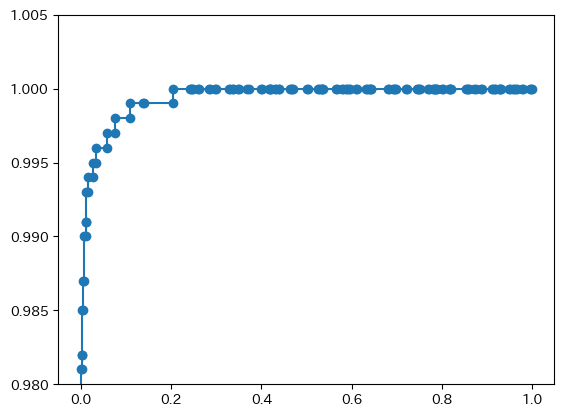

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(ans, pre)
plt.plot(fpr, tpr, marker='o')
plt.ylim(0.98,1.005)
plt.show()

## まとめ
テストデータとして重力波が含まれたスペクトログラム 1000 枚、ノイズのみのスペクトログラム 1000 枚を作成し、構築したモデルに適用した。  
結果は、重力波が含まれたスペクトログラムに対しては 97.2 ％ノイズのみのスペクトログラムに対しては 100 ％の精度で認識することができた。